<a href="https://colab.research.google.com/github/JuanRosales707/laboratoio08-Cuellar/blob/develop/LAB_08_Cuellar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### **Parte A - Carga y preprocesamiento de los datos**

In [2]:
datos = pd.read_csv("/content/drive/MyDrive/colab/cancer.csv")

In [4]:
# Eliminamos columna innecesaria
if "Unnamed: 0" in datos.columns:
    datos = datos.drop(columns=["Unnamed: 0"])

print("Valores nulos por columna:")
print(datos.isna().sum())

Valores nulos por columna:
ClumpThick         0
UnifCellSize       0
UnifCellShape      0
MargAdh            0
SingEpiCellSize    0
BareNuclei         0
BlandChromatin     0
NormalNucleoli     0
Mitoses            0
Class              0
dtype: int64


In [5]:
# Eliminamos valores extremos usando rangos intercuartílicos
for columna in datos.columns[:-1]:  # Evitamos 'Class'
    Q1 = datos[columna].quantile(0.25)
    Q3 = datos[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    datos[columna] = np.where(datos[columna] < limite_inferior, limite_inferior,
                         np.where(datos[columna] > limite_superior, limite_superior, datos[columna]))

In [6]:
variables = datos.drop(columns=["Class"])
objetivo = datos["Class"]

escalador = MinMaxScaler()
variables_normalizadas = escalador.fit_transform(variables)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    variables_normalizadas, objetivo, test_size=0.25, random_state=123, stratify=objetivo)

# --- VERIFICACIÓN DE BALANCE ---
print("\nDistribución de clases:")
print(objetivo.value_counts())


Distribución de clases:
Class
0    458
1    241
Name: count, dtype: int64


### **Parte B - Árbol de Decisión y selección de profundidad**

In [7]:
# Probar varias profundidades
rango_profundidades = list(range(1, 16))
precisiones = []

for p in rango_profundidades:
    arbol = DecisionTreeClassifier(max_depth=p, random_state=123)
    arbol.fit(X_entrenamiento, y_entrenamiento)
    acc = accuracy_score(y_prueba, arbol.predict(X_prueba))
    precisiones.append(acc)

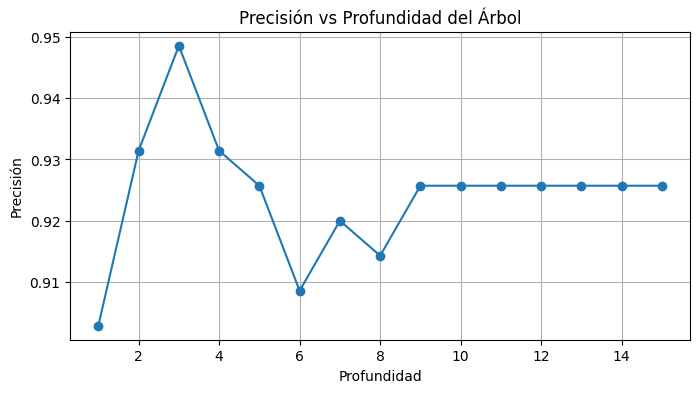

In [8]:
# Graficar resultados
plt.figure(figsize=(8, 4))
plt.plot(rango_profundidades, precisiones, marker='o')
plt.title("Precisión vs Profundidad del Árbol")
plt.xlabel("Profundidad")
plt.ylabel("Precisión")
plt.grid(True)
plt.show()

In [9]:
# Entrenar modelo con la mejor profundidad
mejor_p = rango_profundidades[np.argmax(precisiones)]
print(f"Profundidad óptima encontrada: {mejor_p}")

modelo_arbol_final = DecisionTreeClassifier(max_depth=mejor_p, random_state=123)
modelo_arbol_final.fit(X_entrenamiento, y_entrenamiento)

Profundidad óptima encontrada: 3


DecisionTreeClassifier(max_depth=3, random_state=123)

In [10]:
# Predicciones y métricas
pred_arbol = modelo_arbol_final.predict(X_prueba)

print("\n--- Árbol de Decisión ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_prueba, pred_arbol))
print("\nReporte de Clasificación:")
print(classification_report(y_prueba, pred_arbol))
print(f"Accuracy: {accuracy_score(y_prueba, pred_arbol):.4f}")


--- Árbol de Decisión ---
Matriz de Confusión:
[[110   5]
 [  4  56]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       115
           1       0.92      0.93      0.93        60

    accuracy                           0.95       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.95      0.95      0.95       175

Accuracy: 0.9486


### **Parte C - Bosques Aleatorios y comparación**

In [11]:
# Entrenar Random Forest
bosque = RandomForestClassifier(n_estimators=100, random_state=123)
bosque.fit(X_entrenamiento, y_entrenamiento)
pred_bosque = bosque.predict(X_prueba)

print("\n--- Bosque Aleatorio ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_prueba, pred_bosque))
print("\nReporte de Clasificación:")
print(classification_report(y_prueba, pred_bosque))
print(f"Accuracy: {accuracy_score(y_prueba, pred_bosque):.4f}")


--- Bosque Aleatorio ---
Matriz de Confusión:
[[110   5]
 [  7  53]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       115
           1       0.91      0.88      0.90        60

    accuracy                           0.93       175
   macro avg       0.93      0.92      0.92       175
weighted avg       0.93      0.93      0.93       175

Accuracy: 0.9314


**El Bosque Aleatorio tuvo un mejor desempeño que el Árbol de Decisión, con mayor precisión y métricas más equilibradas. Esto confirma que, al combinar varios árboles, se obtiene un modelo más robusto y confiable. En resumen, sí hubo mejoras claras al usar Bosques Aleatorios.**